In [1]:
import time
import torch
import json
import random
import math
import warnings
import torchvision
import os
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torchvision.models as models

from pathlib import Path
from datetime import datetime
from tqdm import tqdm
from PIL import Image
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision.models import EfficientNet
from torchvision.datasets import ImageFolder

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# Hyperparameters
learning_rate = 0.0005 # 0.096779
epochs = 3
epochs_pretrain = 3
epochs_optimal_lr = 3
patience = 6
momentum = 0.9
step_size = 30
gamma = 0.1
batch_size = 64
num_workers = 4

# list of lambda values to loop through for grid search
lmda_list = [5,0]

# labels used including for plotting
class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]
class_labels_new = torch.tensor([i for i in range(len(class_labels))])
num_classes = 16
class_names_new = [f"Class {label}" for label in range(num_classes)]


In [3]:
# set device to cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Check if CUDA is available
cuda_available = torch.cuda.is_available()

# Count the number of GPUs available
num_gpus = torch.cuda.device_count()

print("CUDA Available:", cuda_available)
print("Number of GPUs:", num_gpus)

torch.cuda.empty_cache()

CUDA Available: True
Number of GPUs: 1


In [4]:
# Assuming your JSON file is named 'your_file.json'
file_path = './WIDER/Annotations/wider_attribute_trainval.json'

with open(file_path, 'r') as file:
    # Load the JSON data from the file
    data = json.load(file)

class_idx = data['scene_id_map']

In [5]:
new_label_mapping = {
    0: "Team_Sports",
    1: "Celebration",
    2: "Parade",
    3: "Waiter_Or_Waitress",
    4: "Individual_Sports",
    5: "Surgeons",
    6: "Spa",
    7: "Law_Enforcement",
    8: "Business",
    9: "Dresses",
    10: "Water_Activities",
    11: "Picnic",
    12: "Rescue",
    13: "Cheering",
    14: "Performance_And_Entertainment",
    15: "Family"
}

# Ensure that all 16 new classes are covered
# If some classes are not explicitly mentioned in new_label_mapping, add them
for i in range(num_classes):
    if i not in new_label_mapping:
        new_label_mapping[i] = "Additional Category {}".format(i)

class_idx = new_label_mapping

In [6]:
class DataSet(Dataset):
    def __init__(self, ann_files, augs, img_size, dataset):

        # Create a mapping from old labels to new labels
        self.label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted(class_labels))}

        self.new_label_mapping = {
            0: 2,  # Parade
            1: 8,  # Business
            2: 7,  # Law Enforcement
            3: 14,  # Performance and Entertainment
            4: 1,  # Celebration
            5: 13,  # Cheering
            6: 8,  # Business
            7: 8,  # Business
            8: 1,  # Celebration
            9: 14,  # Performance and Entertainment
            10: 15, # Family
            11: 15, # Family
            12: 11, # Picnic
            13: 7, # Law Enforcement
            14: 6, # Spa
            15: 13, # Cheering
            16: 5, # Surgeons
            17: 3, # Waiter or Waitress
            18: 4, # Individual Sports
            19: 0, # Team Sports
            20: 0, # Team Sports
            21: 0, # Team Sports
            22: 4, # Individual Sports
            23: 10, # Water Activities
            24: 4, # Individual Sports
            25: 1, # Celebration
            26: 9, # Dresses
            27: 12, # Rescue
            28: 10,# Water Activities
            29: 0  # Team Sports
        }

        self.dataset = dataset
        self.ann_files = ann_files
        self.augment = self.augs_function(augs, img_size)
        # Initialize transformations directly
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
            ] 
        )
        if self.dataset == "wider":
            self.transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                ] 
            )        

        self.anns = []
        self.load_anns()
        print(self.augment)

    def augs_function(self, augs, img_size):            
        t = []
        if 'randomflip' in augs:
            t.append(transforms.RandomHorizontalFlip())
        if 'ColorJitter' in augs:
            t.append(transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0))
        if 'resizedcrop' in augs:
            t.append(transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)))
        if 'RandAugment' in augs:
            t.append(transforms.RandAugment())

        t.append(transforms.Resize((img_size, img_size)))

        return transforms.Compose(t)
    
    def load_anns(self):
        self.anns = []
        for ann_file in self.ann_files:
            json_data = json.load(open(ann_file, "r"))
            self.anns += json_data

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        # Make sure the index is within bounds
        idx = idx % len(self)
        ann = self.anns[idx]
        
        try:
            # Attempt to open the image file
            img = Image.open(f'WIDER/Image/{ann["file_name"]}').convert("RGB")

            # If this is the wider dataset, proceed with specific processing
            # x, y, w, h = ann['bbox']
            # img_area = img.crop([x, y, x+w, y+h])
            img_area = self.augment(img)
            img_area = self.transform(img_area)
            attributes_list = [target['attribute'] for target in ann['targets']]
            num_people = len(attributes_list)
            attributes_distribution = [max(sum(attribute), 0)/num_people for attribute in zip(*attributes_list)]
            # Extract label from image path
            img_path = f'WIDER/Image/{ann["file_name"]}'
            label = self.extract_label(img_path)  # You might need to implement this method
            
            return {
                "label": label,
                "target": torch.tensor([attributes_distribution[0]], dtype=torch.float32),
                "img": img_area
            }
            
        except Exception as e:
            # If any error occurs during the processing of an image, log the error and the index
            print(f"Error processing image at index {idx}: {e}")
            # Instead of returning None, raise the exception
            raise

    def extract_label(self, img_path):
        original_label = None
    
        if "WIDER/Image/train" in img_path:
            label_str = img_path.split("WIDER/Image/train/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/test" in img_path:
            label_str = img_path.split("WIDER/Image/test/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/val" in img_path:  # Handle validation images
            label_str = img_path.split("WIDER/Image/val/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
    
        if original_label is not None:
            remapped_label = self.label_mapping[original_label]
            new_label_mapping = self.new_label_mapping[remapped_label]
            return new_label_mapping
        else:
            raise ValueError(f"Label could not be extracted from path: {img_path}")


In [7]:
train_file = ['data/wider/trainval_wider.json']
test_file = ['data/wider/test_wider.json']


In [8]:
def custom_collate(batch):
    # Filter out any None items in the batch
    batch = [item for item in batch if item is not None]
    # If after filtering the batch is empty, handle this case by either returning an empty tensor or raising an exception
    if len(batch) == 0:
        raise ValueError("Batch is empty after filtering out None items.")
    return torch.utils.data.dataloader.default_collate(batch)


In [9]:
# train_dataset = DataSet(train_file, augs = ['RandAugment'], img_size = 226, dataset = 'wider')
train_dataset = DataSet(train_file, augs = [], img_size = 226, dataset = 'wider')
test_dataset = DataSet(test_file, augs = [], img_size = 226, dataset = 'wider')

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                         num_workers=num_workers, collate_fn=custom_collate)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=custom_collate)


Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)
Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)


In [10]:
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

def calculate_recall_multiclass(conf_matrix):
    if conf_matrix.size == 0:
        return np.array([0])  # Return an array with a single zero if the confusion matrix is empty

    recalls = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    recalls[np.isnan(recalls)] = 0  # Replace NaN with 0
    return recalls  # This will always be an array

def evaluate_model_with_gender_multiclass(pred, label, gender, num_classes):
    predictions = pred.cpu().numpy()
    true_labels = label.cpu().numpy()
    gender = gender.cpu().numpy()

    class_disparities = []  # This is the correct variable name
    batch_biases = []  # Store batch biases

    for cls in range(num_classes):
        male_indices = np.where((gender >= 0.5) & (true_labels == cls))[0]
        female_indices = np.where((gender < 0.5) & (true_labels == cls))[0]

        if len(male_indices) > 0 and len(female_indices) > 0:
            male_pred_cls = predictions[male_indices]
            female_pred_cls = predictions[female_indices]
            male_true_cls = true_labels[male_indices]
            female_true_cls = true_labels[female_indices]

            # Ensure that both male and female true labels contain the class 'cls'
            if cls in male_true_cls and cls in female_true_cls:
                male_conf_matrix = confusion_matrix(male_true_cls, male_pred_cls, labels=[cls])
                female_conf_matrix = confusion_matrix(female_true_cls, female_pred_cls, labels=[cls])

                if male_conf_matrix.size > 0 and female_conf_matrix.size > 0:
                    male_recall_cls = calculate_recall_multiclass(male_conf_matrix)[0]  # Take first element
                    female_recall_cls = calculate_recall_multiclass(female_conf_matrix)[0]  # Take first element

                    disparity = np.abs(male_recall_cls - female_recall_cls)
                    class_disparities.append(disparity)  # Append to class_disparities
                    batch_biases.append(disparity)  # Append to batch_biases

    return np.mean(batch_biases) if batch_biases else 0, class_disparities



In [11]:
# Load EfficientNet B0 model
model = models.efficientnet_b0(pretrained=True)

# Determine the number of output features from the feature extractor part of EfficientNet B0
num_ftrs = model.classifier[1].in_features  # This is the correct number of input features for your adversarial classifier

# Modify the classifier layer of the EfficientNet model to match your number of classes
model.classifier[1] = nn.Linear(num_ftrs, num_classes)

# Move the EfficientNet model to the GPU
model = model.to(device)

class Critic(nn.Module):
    def __init__(self, input_size, hidden_size=256):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)  # Outputting a single value for bias

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))  # Assuming bias is a probability-like value
        return x

# Initialize the Critic model
critic = Critic(input_size=16).to(device)  # Adjust the input size based on your model's output
critic_optimizer = optim.Adam(critic.parameters(), lr=learning_rate)
critic_loss_fn = torch.nn.MSELoss()

# Redefine your main model optimizer if needed
actor_optimizer = optim.Adam(model.parameters(), lr=learning_rate)
actor_loss_fn = nn.CrossEntropyLoss()


In [12]:
lambda_factor = 3
epsilon = 0.1
margin = 0.1


Epoch 1/3, Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.29it/s]


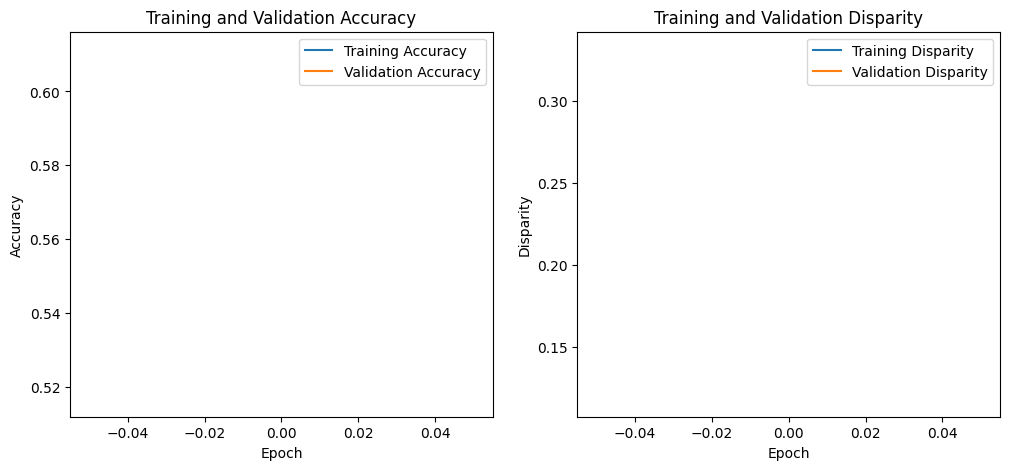

Epoch 1: Training Accuracy = 0.5165895061728395, Validation Accuracy = 0.6114583335139535
Epoch 1: Training Disparity = 0.3316498145201849, Validation Disparity = 0.11818181818181818


Epoch 2/3, Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.31it/s]


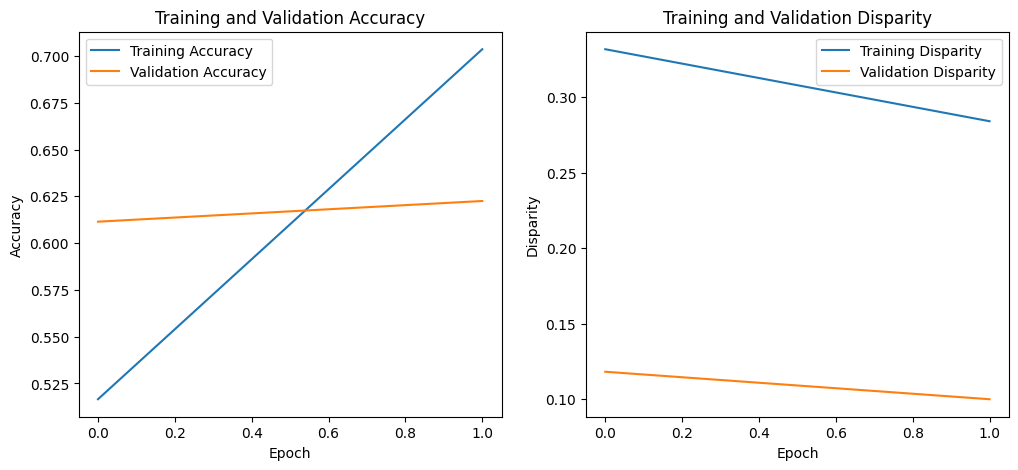

Epoch 2: Training Accuracy = 0.7036072530864198, Validation Accuracy = 0.6225063131614165
Epoch 2: Training Disparity = 0.2839908890834817, Validation Disparity = 0.1


Epoch 3/3, Validation:  95%|██████████████████████████████████████████████████████████████████████████████████████     | 52/55 [00:16<00:00,  4.27it/s]

In [ ]:
train_accuracies = []
train_disparities = []
val_accuracies = []
val_disparities = []

# Training and Validation Loop
for epoch in range(epochs):
    # Initialize metrics for each epoch
    epoch_train_accuracies = []
    epoch_train_disparities = []
    epoch_val_accuracies = []
    epoch_val_disparities = []
    epoch_class_disparities = []

    # Training
    model.train()
    for batch_data in tqdm(trainloader, desc=f'Epoch {epoch+1}/{epochs}, Training'):
        # Load data to device
        images = batch_data["img"].to(device)
        labels = batch_data["label"].to(device)
        gender_scores = batch_data["target"].to(device)

        # Forward pass through actor
        actor_output = model(images)
        class_predictions = torch.argmax(actor_output, dim=1)

        # Compute bias
        bias, class_disparities = evaluate_model_with_gender_multiclass(class_predictions, labels, gender_scores, num_classes)
        bias_mean = torch.tensor([bias], device=device, dtype=torch.float32)

        # Actor update
        actor_optimizer.zero_grad()
        main_loss = actor_loss_fn(actor_output, labels)
        combined_loss = main_loss + lambda_factor * bias_mean
        combined_loss.backward()
        actor_optimizer.step()

        # Critic update
        critic_optimizer.zero_grad()
        critic_output = critic(actor_output.detach())
        critic_loss = critic_loss_fn(critic_output, bias_mean)
        critic_loss.backward()
        critic_optimizer.step()

        # Calculate and accumulate metrics
        accuracy = (class_predictions == labels).float().mean().item()
        epoch_train_accuracies.append(accuracy)
        epoch_train_disparities.append(bias)

    # Store average training metrics for the epoch
    train_accuracy = np.mean(epoch_train_accuracies)
    train_disparity = np.mean(epoch_train_disparities)
    train_accuracies.append(train_accuracy)
    train_disparities.append(train_disparity)

    # Validation Phase
    model.eval()
    with torch.no_grad():
        for batch_data in tqdm(testloader, desc=f'Epoch {epoch+1}/{epochs}, Validation'):
            # Load data to device
            images = batch_data["img"].to(device)
            labels = batch_data["label"].to(device)
            gender_scores = batch_data["target"].to(device)

            # Forward pass
            actor_output = model(images)
            class_predictions = torch.argmax(actor_output, dim=1)

            # Calculate and accumulate validation metrics
            accuracy = (class_predictions == labels).float().mean().item()
            mean_batch_bias, _ = evaluate_model_with_gender_multiclass(class_predictions, labels, gender_scores, num_classes)
            epoch_val_accuracies.append(accuracy)
            epoch_val_disparities.append(mean_batch_bias)
            _, class_disparity = evaluate_model_with_gender_multiclass(class_predictions, labels, gender_scores, num_classes)
            
    if epoch_class_disparities:
        max_len = max(len(x) for x in epoch_class_disparities)
        padded_disparities = np.array([np.pad(x, (0, max_len - len(x)), mode='constant', constant_values=np.nan) for x in epoch_class_disparities])
        epoch_average_class_disparities = np.nanmean(padded_disparities, axis=0)
    else:
        epoch_average_class_disparities = []
     
    epoch_average_class_disparities = np.mean(epoch_class_disparities, axis=0) if epoch_class_disparities else []

    # Store average validation metrics for the epoch
    val_accuracy = np.mean(epoch_val_accuracies)
    val_disparity = np.mean(epoch_val_disparities)
    val_accuracies.append(val_accuracy)
    val_disparities.append(val_disparity)

    # Plotting after each epoch
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_disparities, label='Training Disparity')
    plt.plot(val_disparities, label='Validation Disparity')
    plt.xlabel('Epoch')
    plt.ylabel('Disparity')
    plt.title('Training and Validation Disparity')
    plt.legend()
    plt.show()

    # Logging epoch metrics
    print(f"Epoch {epoch + 1}: Training Accuracy = {train_accuracy}, Validation Accuracy = {val_accuracy}")
    print(f"Epoch {epoch + 1}: Training Disparity = {train_disparity}, Validation Disparity = {val_disparity}")
    # Print class-level disparities for the epoch
    for cls, disparity in enumerate(epoch_average_class_disparities):
        print(f"Epoch {epoch + 1}: Class {cls} Disparity: {disparity}")

In [ ]:
# """
# Adversarial Intraprocessing Algorithm.
# """
# import logging

# import numpy as np
# import torch
# import torch.optim as optim

# from models import load_model, Critic
# from utils import get_best_thresh, get_test_objective, get_valid_objective, compute_bias

# logger = logging.getLogger("Debiasing")


# def adversarial_debiasing(model_state_dict, data, config, device):
#     logger.info('Training Adversarial model.')
#     actor = load_model(data.num_features, config.get('hyperparameters', {}))
#     actor.load_state_dict(model_state_dict)
#     actor.to(device)
#     hid = config['hyperparameters']['hid'] if 'hyperparameters' in config else 32
#     critic = Critic(hid * config['adversarial']['batch_size'], num_deep=config['adversarial']['num_deep'], hid=hid)
#     critic.to(device)
#     critic_optimizer = optim.Adam(critic.parameters())
#     critic_loss_fn = torch.nn.MSELoss()

#     actor_optimizer = optim.Adam(actor.parameters(), lr=config['adversarial']['lr'])
#     actor_loss_fn = torch.nn.BCELoss()

#     for epoch in range(config['adversarial']['epochs']):
#         for param in critic.parameters():
#             param.requires_grad = True
#         for param in actor.parameters():
#             param.requires_grad = False
#         actor.eval()
#         critic.train()
#         for step in range(config['adversarial']['critic_steps']):
#             critic_optimizer.zero_grad()
#             indices = torch.randint(0, data.X_valid.size(0), (config['adversarial']['batch_size'],))
#             cX_valid = data.X_valid_gpu[indices]
#             cy_valid = data.y_valid[indices]
#             cp_valid = data.p_valid[indices]
#             with torch.no_grad():
#                 scores = actor(cX_valid)[:, 0].reshape(-1).cpu().numpy()

#             bias = compute_bias(scores, cy_valid.numpy(), cp_valid, config['metric'])

#             res = critic(actor.trunc_forward(cX_valid))
#             loss = critic_loss_fn(torch.tensor([bias], device=device), res[0])
#             loss.backward()
#             train_loss = loss.item()
#             critic_optimizer.step()
#             if (epoch % 10 == 0) and (step % 100 == 0):
#                 logger.info(f'=======> Critic Epoch: {(epoch, step)} loss: {train_loss}')

#         for param in critic.parameters():
#             param.requires_grad = False
#         for param in actor.parameters():
#             param.requires_grad = True
#         actor.train()
#         critic.eval()
#         for step in range(config['adversarial']['actor_steps']):
#             actor_optimizer.zero_grad()
#             indices = torch.randint(0, data.X_valid.size(0), (config['adversarial']['batch_size'],))
#             cy_valid = data.y_valid_gpu[indices]
#             cX_valid = data.X_valid_gpu[indices]

#             pred_bias = critic(actor.trunc_forward(cX_valid)) # outputs of adversary model
#             bceloss = actor_loss_fn(actor(cX_valid)[:, 0], cy_valid)

#             # loss = lam*abs(pred_bias) + (1-lam)*loss   

#             # max(1, lambda * abs(outputs of adversary model) - epsilon (hypderparam) + margin + 1)
#             # epsilon = target bias (0.09?)
#             # margin = margin of error
#             objloss = max(1, config['adversarial']['lambda']*(abs(pred_bias[0][0])-config['objective']['epsilon']+config['adversarial']['margin'])+1) * bceloss
#             # ce-loss instead of BCE
#             # dont need to binarize
            
#             objloss.backward()
#             train_loss = objloss.item()
#             actor_optimizer.step()
#             if (epoch % 10 == 0) and (step % 100 == 0):
#                 logger.info(f'=======> Actor Epoch: {(epoch, step)} loss: {train_loss}')

#         if epoch % 10 == 0:
#             with torch.no_grad():
#                 scores = actor(data.X_valid_gpu)[:, 0].reshape(-1, 1).cpu().numpy()
#                 _, best_adv_obj = get_best_thresh(scores, np.linspace(0, 1, 1001), data, config, valid=False, margin=config['adversarial']['margin'])
#                 logger.info(f'Objective: {best_adv_obj}')

#     logger.info('Finding optimal threshold for Adversarial model.')
#     with torch.no_grad():
#         scores = actor(data.X_valid_gpu)[:, 0].reshape(-1, 1).cpu().numpy()

#     best_adv_thresh, _ = get_best_thresh(scores, np.linspace(0, 1, 1001), data, config, valid=False, margin=config['adversarial']['margin'])

#     logger.info('Evaluating Adversarial model on best threshold.')
#     with torch.no_grad():
#         labels = (actor(data.X_valid_gpu)[:, 0] > best_adv_thresh).reshape(-1, 1).cpu().numpy()
#     results_valid = get_valid_objective(labels, data, config)
#     logger.info(f'Results: {results_valid}')

#     with torch.no_grad():
#         labels = (actor(data.X_test_gpu)[:, 0] > best_adv_thresh).reshape(-1, 1).cpu().numpy()
#     results_test = get_test_objective(labels, data, config)

#     # return results_valid, results_test